# DATA2001 Assingment 3

## Data Preparation

In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv("amzn.us.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [19]:
print(type(df['Date'][2])) 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**Exogenous Data: VIX Index**

"Volatility Index, a popular measure of the stock market's expectation of volatility based on S&P 500 index options. It is calculated and disseminated on a real-time basis by the CBOE, and is often referred to as the fear index or fear gauge." Source: [Wikipedia](https://en.wikipedia.org/wiki/VIX)

It is useful exogenous variable because it gives a broad sense of the state the world in relation to the market. It is highly correlated to news events that are expected to negativly effect markets. In this case it is presented as a 30-day expection of volatility given a weighted portfolio of european options on the S&P 500. Its sourced from  [Yahoo Finance](https://finance.yahoo.com/quote/%5EVIX?p=%5EVIX) for the relevant period. 

In [20]:
vix = pd.read_csv('VIX.csv')
vix.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-16,18.730000,21.820000,18.580000,21.570000,21.570000,0
1,1997-05-19,21.879999,21.950001,21.260000,21.480000,21.480000,0
2,1997-05-20,21.490000,21.719999,19.129999,19.260000,19.260000,0
3,1997-05-21,19.190001,19.620001,18.820000,19.280001,19.280001,0
4,1997-05-22,19.010000,19.240000,18.680000,18.770000,18.770000,0


In [21]:
#Dropping unneeded columns and keeping close for merge with amazon dataset
vix=vix['Close']
vix = vix.rename('VIXClose')
df['VIX Close']= vix

# Exploratory Analysis

In [22]:
import seaborn as sns 
from datetime import datetime, date 

f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlabel('')
                      
    ax[i].set_xlim([date(1997, 5, 16), date(2017, 11, 9)])      

NameError: name 'plt' is not defined

Some comments on the patterns visible. 

# Decomposition 

In [ ]:
# Split data into training and test sets
train = df.iloc[:5081,:]
test = df.iloc[5081:,:]

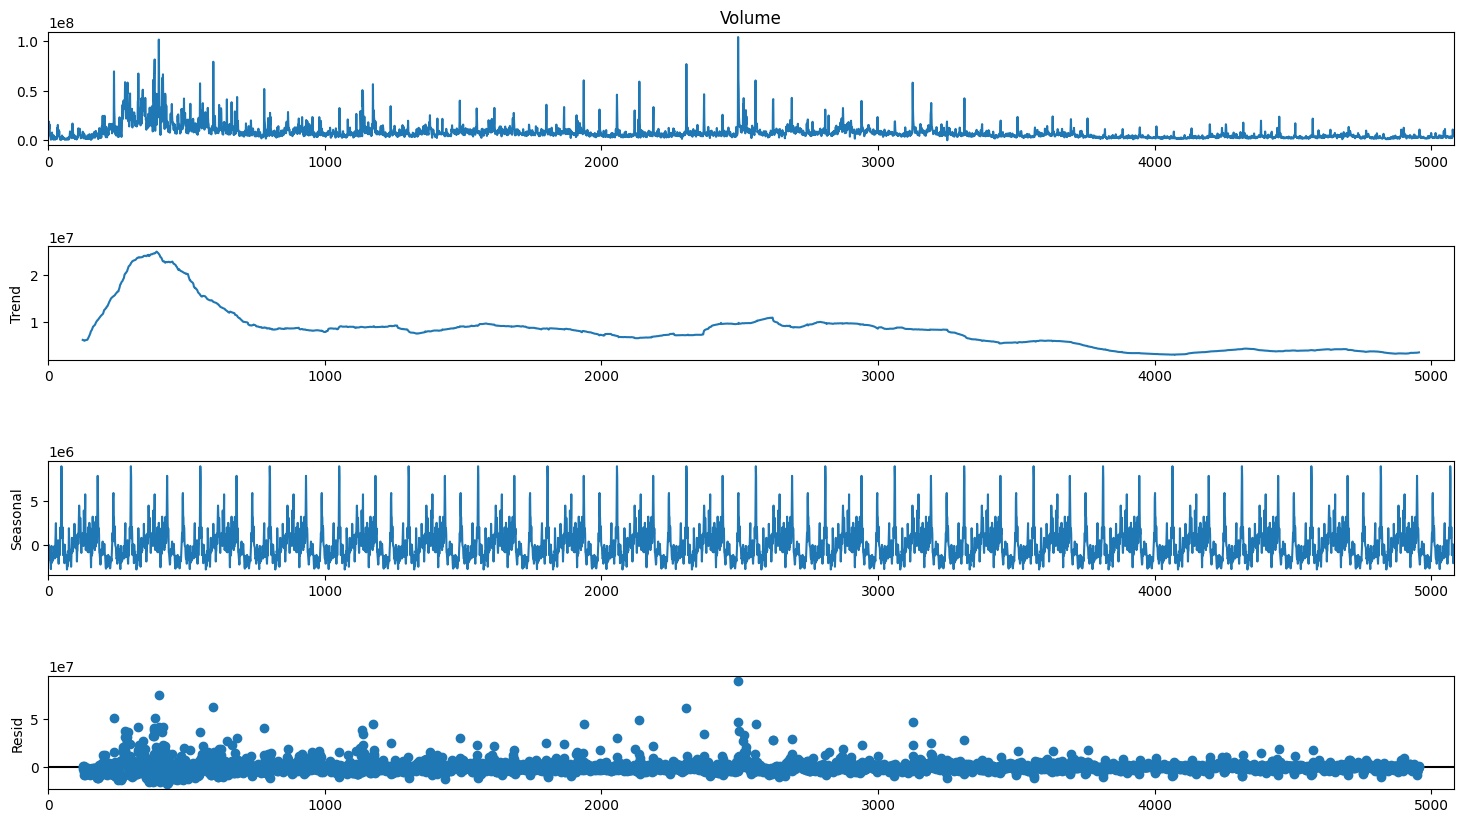

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(train['Volume'],period = 251)
fig = str_res.plot()
fig.set_size_inches((16, 9))

### Isolating Trend

<AxesSubplot:>

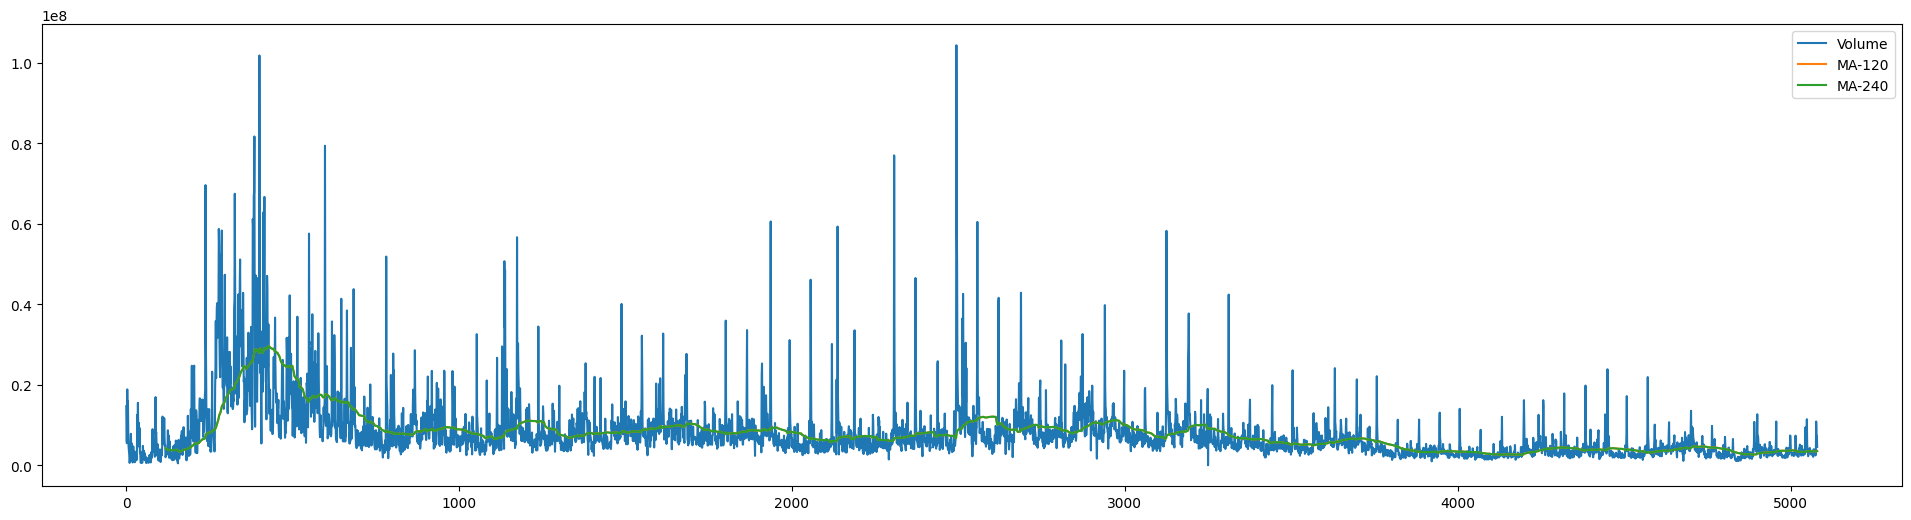

In [74]:
# There are 5 observations per week
train['MA-60'] = train['Volume'].rolling(60).mean()
train['MA-120'] = train['Volume'].rolling(120).mean()

train[['Volume','MA-120','MA-240']].plot(figsize=(24,6))

The MA-120 appears to be too long. You can determine this by observings the effect big changes have on it and how it appears to 'lag' a little more then MA-60.


### De-trending

<AxesSubplot:>

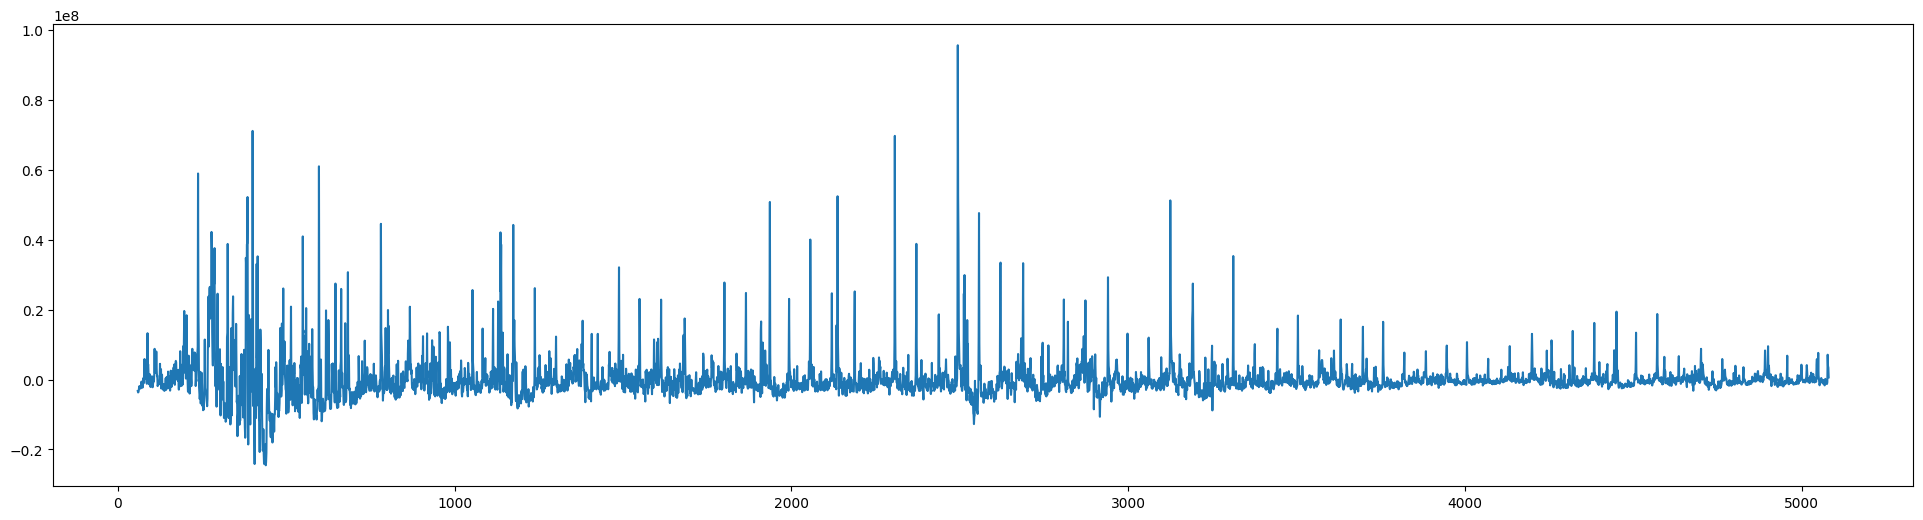

In [ ]:
train['vol-detrended'] = train['Volume'] - train['MA-120']
train['vol-detrended'].plot(figsize=(24,6))

### Seasonality Component 

In [106]:
weekly_means = train.groupby(np.arange(len(train))//5)['vol-detrended'].mean()

<AxesSubplot:>

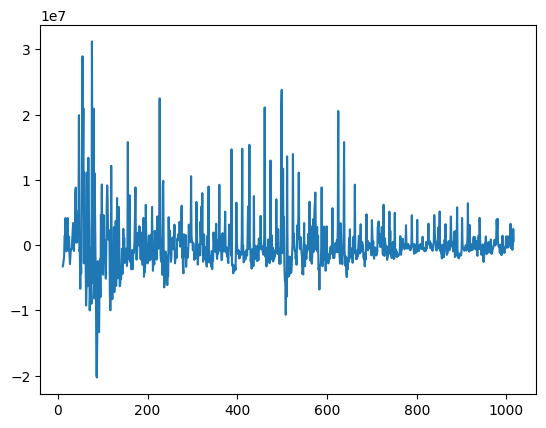

In [107]:

weekly_means.plot()

<AxesSubplot:>

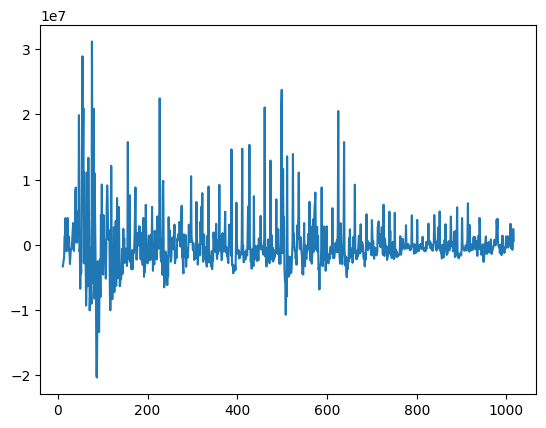

In [108]:
# Adjust seasonal component so that it sums to zero. 
adjustment = weekly_means.sum()/5.0
weekly_means = weekly_means - adjustment
weekly_means.plot()

In [110]:
seasonal = np.tile(weekly_means,int(np.floor(len(train)/5)))
train['vol-seasonal'] = seasonal
train['vol-seasonal'].plot(figsize=(24,6))

ValueError: Length of values (1033272) does not match length of index (5081)

### Residual

In [ ]:
train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']
train['vol-residual'].plot(figsize=(24,6))